In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

In [4]:
def kernel(X1, X2, scale=1.0, sigma_f=1.0):
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#    ''' Uncomment for Linear Kernel '''
#    return X1 @ X2.T
def dataSet2():
    X, y = make_moons(n_samples=100, noise=0.1)
    y = np.where(y==0, -1, y)
    y = y.reshape(-1,1)
    S = (y>0).squeeze()
    x_pos = X[S]
    x_neg = X[np.invert(S)]
    return X,y,x_pos,x_neg

In [3]:
def dualOptimizer_hardmargins(H,m,y):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(-np.eye(m))
    h = cvxopt_matrix(np.zeros(m))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

def dualOptimizer_softmargins(H,m,y,C):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye((m)), np.eye(m))))
    h = cvxopt_matrix(np.vstack((np.zeros((m,1)), np.ones((m,1)) * C)))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas


def pred(y,a,X,p,b):
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)


In [5]:
''' Implementing SVM hard margin '''
'''Converting second term of dual objective function into standard form, a.T*H*a for the optimizer'''
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape
C=10000  #Taking C to be 10000 in the constraint. For a higher value of C we get a more stricter margin for the dataset as seen in the observation below 
alphas_hard = dualOptimizer_hardmargins(H,m,y)
alphas_soft = dualOptimizer_softmargins(H,m,y,C)
#Selecting the set of indices S corresponding to non zero parameters
S = (alphas_hard > 1e-4).flatten()
S1= (alphas_soft > 1e-4).flatten()
w = ((y[S] * alphas_hard[S]).T @ X[S]).reshape(-1,1)
w1= ((y[S] * alphas_soft[S]).T @ X[S]).reshape(-1,1)
#Computing b
b = predb(y[S],alphas_hard[S],X[S],X[S])
b1= predb(y[S],alphas_soft[S],X[S],X[S])

#Display results
print('Alphas for hard margins: ',alphas_hard,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_hard[alphas_hard > 1e-4])
print('w = ', w.flatten())
print('b = ', b)

(9, 9) (1, 9)
(9, 9) (1, 9)
Alphas for hard margins:  [[1.25982934e-11]
 [3.87624031e-11]
 [1.59762869e-11]
 [7.27948143e+01]
 [1.08156510e-10]
 [6.71853097e-11]
 [1.96409980e-11]
 [3.18282997e-11]
 [6.06586656e-11]
 [4.50594970e-11]
 [1.15192035e-11]
 [4.85708149e-11]
 [7.45434637e-11]
 [6.06780180e-11]
 [5.48202274e-11]
 [2.43994418e-11]
 [1.02115080e-09]
 [6.19020458e+00]
 [1.68827090e-11]
 [1.35798143e-11]
 [2.72837113e-11]
 [1.44821407e-11]
 [9.36921132e-11]
 [1.39000025e-11]
 [2.89653376e-11]
 [6.16313007e-11]
 [4.51903996e-11]
 [8.04099883e-11]
 [3.02114283e-11]
 [1.06345170e-10]
 [3.26379048e-11]
 [7.35247673e-11]
 [2.97192362e-10]
 [3.94271362e-11]
 [3.25308620e-11]
 [2.86288213e-11]
 [2.15274571e-11]
 [4.30993400e-11]
 [2.55644881e-10]
 [4.73395075e-11]
 [5.98766102e-11]
 [3.13355688e-11]
 [2.14480385e+01]
 [5.35426952e-11]
 [2.57000739e-11]
 [2.99685905e-11]
 [2.02130444e-11]
 [6.29098220e-11]
 [3.03540880e+01]
 [9.99731426e+00]
 [3.56265401e-11]
 [2.34613643e-11]
 [1.358033

In [6]:
print('Alphas for soft margins: ',alphas_soft,'\n Support Vectors: ',S1.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_soft[alphas_soft > 1e-4])
print('w = ', w1.flatten())
print('b = ', b1)

Alphas for soft margins:  [[7.35175892e-13]
 [1.87562788e-12]
 [9.51934571e-13]
 [7.27948143e+01]
 [6.46294265e-12]
 [2.21407083e-12]
 [1.12645332e-12]
 [2.04321160e-12]
 [3.45578867e-12]
 [2.53226630e-12]
 [6.59527355e-13]
 [2.43556687e-12]
 [4.04183203e-12]
 [2.88561081e-12]
 [2.56669723e-12]
 [1.41990579e-12]
 [2.41084123e-11]
 [6.19020458e+00]
 [8.56250374e-13]
 [8.09252434e-13]
 [1.70334398e-12]
 [8.98199978e-13]
 [4.13794042e-12]
 [8.09507814e-13]
 [1.45067415e-12]
 [2.08096601e-12]
 [2.39276480e-12]
 [2.57679027e-12]
 [1.79904745e-12]
 [3.72314421e-12]
 [1.90611438e-12]
 [4.44359044e-12]
 [1.17745605e-11]
 [1.53007676e-12]
 [1.69813869e-12]
 [1.72187399e-12]
 [1.19989335e-12]
 [2.65671898e-12]
 [1.31514590e-11]
 [2.51677032e-12]
 [3.81782056e-12]
 [1.53633590e-12]
 [2.14480385e+01]
 [3.52368355e-12]
 [1.36047324e-12]
 [1.57894856e-12]
 [1.20316683e-12]
 [2.28781223e-12]
 [3.03540880e+01]
 [9.99731426e+00]
 [1.72674178e-12]
 [1.41603042e-12]
 [6.10376555e-12]
 [6.11305933e-13]
 [

<a list of 3 text.Text objects>

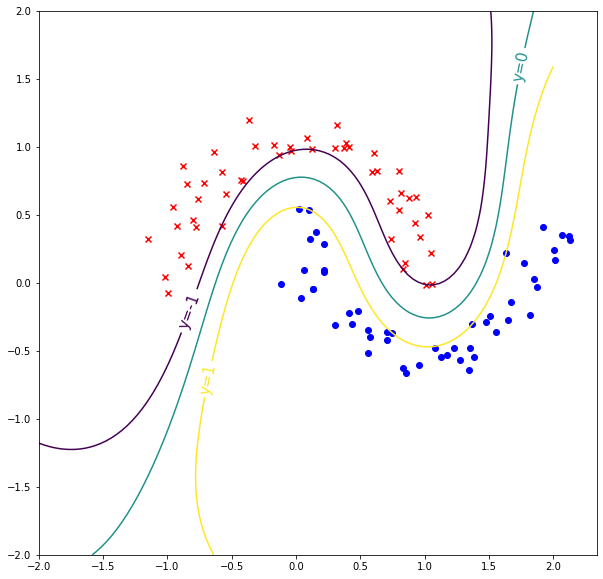

In [7]:
fig = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas_hard[S],X[S],p,b)
#print(pr)
'''hardmargin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp = plt.contour(x0, x1, pred(y[S],alphas_hard[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=15)

<a list of 3 text.Text objects>

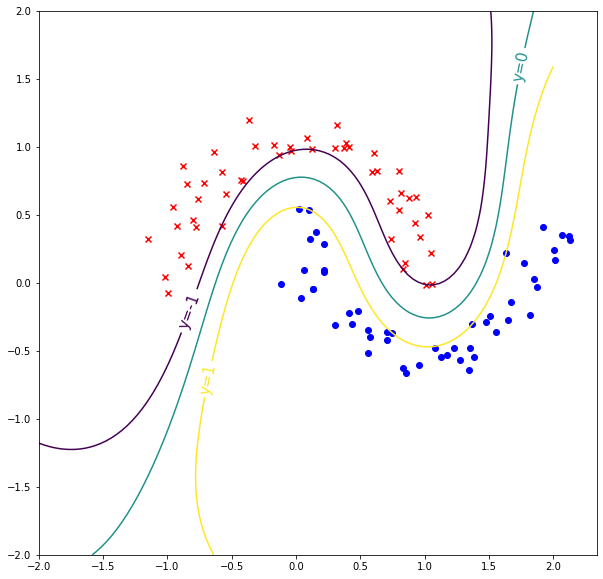

In [8]:
fig1 = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x_0, x_1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p1 = np.array([x_0, x_1]).reshape(2, -1).T
pr1 = pred(y[S],alphas_soft[S],X[S],p1,b1)
#print(pr)
'''softmargin hyperplanes for C=10000'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp1 = plt.contour(x_0, x_1, pred(y[S],alphas_soft[S],X[S],p1,b1).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp1, fmt='y=%.f', inline=True, fontsize=15)